# Calibration of the Energy Balance Model

## Load Environment

In [2]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/BEE4850/website/slides`


In [3]:
using Distributions
using StatsBase
using CSV
using DataFrames
using Optim
using Turing
using Plots
using StatsPlots

## Load Data

In [114]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
dat_path = joinpath(@__DIR__, "..", "data", "climate")
forcings_all_85 = CSV.read(joinpath(dat_path, "ERF_ssp585_1750-2500.csv"), DataFrame, delim=",")

# Separate out the individual components
forcing_co2_85 = forcings_all_85[!,"co2"]
# Get total aerosol forcings
forcing_aerosol_rad_85 = forcings_all_85[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud_85 = forcings_all_85[!,"aerosol-cloud_interactions"]
forcing_aerosol_85 = forcing_aerosol_rad_85 + forcing_aerosol_cloud_85
forcing_total_85 = forcings_all_85[!,"total"]
forcing_non_aerosol_85 = forcing_total_85 - forcing_aerosol_85
forcing_other_85 = forcing_total_85 - (forcing_co2_85 + forcing_aerosol_85)

forcings_all_26 = CSV.read(joinpath(dat_path, "ERF_ssp126_1750-2500.csv"), DataFrame, delim=",")

# Separate out the individual components
forcing_co2_26 = forcings_all_26[!,"co2"]
# Get total aerosol forcings
forcing_aerosol_rad_26 = forcings_all_26[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud_26 = forcings_all_26[!,"aerosol-cloud_interactions"]
forcing_aerosol_26 = forcing_aerosol_rad_26 + forcing_aerosol_cloud_26
forcing_total_26 = forcings_all_26[!,"total"]
forcing_non_aerosol_26 = forcing_total_26 - forcing_aerosol_26
forcing_other_26 = forcing_total_26 - (forcing_co2_26 + forcing_aerosol_26)

t = time_forcing = Int64.(forcings_all_85[!,"year"]) # Ensure that years are interpreted as integers
sim_years = 1850:2100 # model years for projections
sim_idx = indexin(sim_years, t)

temps = CSV.read(joinpath(dat_path, "HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv"), DataFrame, delim=",")

time_obs = temps[:, 1]
temp_obs = temps[:, 2]
temp_lo = temps[:, 3]
temp_hi = temps[:, 4]

# generate simulations
hind_years = 1850:2022 # model years to simulate for fitting
sim_years = 1850:2100 # model years for projections
idx = indexin(hind_years, t) # find indices in t vector of simulation years
sim_idx = indexin(sim_years, t)

temp_obs = temp_obs[indexin(hind_years, time_obs)] # filter to simulated years for plotting
temp_lo = temp_lo[indexin(hind_years, time_obs)] # filter to simulated years for plotting
temp_hi = temp_hi[indexin(hind_years, time_obs)] # filter to simulated years for plotting
@show temp_lo;
@show temp_hi;
@show temp_obs;

temp_lo = temp_lo .- mean(temp_obs[1:20]) # re-normalize to be consistent with the model
temp_hi = temp_hi .- mean(temp_obs[1:20]) # re-normalize to be consistent with the model
temp_obs = temp_obs .- mean(temp_obs[1:20]) # re-normalize to be consistent with the model
temp_sd = (temp_hi - temp_lo) / 2 # estimate standard deviation using 95% CI

temp_lo = [-0.589203, -0.41186792, -0.40938243, -0.43000934, -0.43282393, -0.43935776, -0.46809322, -0.61632216, -0.53688604, -0.42384982, -0.5389766, -0.5972301, -0.7037096, -0.5341645, -0.6480974, -0.5246526, -0.52183825, -0.55306214, -0.52965826, -0.47642276, -0.46867347, -0.5141493, -0.4630833, -0.4725396, -0.5071426, -0.514041, -0.56287116, -0.22982001, -0.13121258, -0.43406433, -0.44015095, -0.35793498, -0.4201501, -0.4608177, -0.6026686, -0.5830682, -0.5225382, -0.61655986, -0.49332377, -0.37222093, -0.6324095, -0.5373699, -0.64432853, -0.6315314, -0.6255681, -0.58202064, -0.4174015, -0.39852425, -0.6176492, -0.48639694, -0.3669676, -0.42967388, -0.5754281, -0.66081935, -0.7288325, -0.5350291, -0.45052385, -0.6262818, -0.63748026, -0.6526296, -0.6556868, -0.66223973, -0.5893311, -0.5893755, -0.38276345, -0.32196194, -0.5588941, -0.6921192, -0.58198184, -0.48145813, -0.44860035, -0.38175339, -0.46610323, -0.444173, -0.4388317, -0.4147755, -0.25264767, -0.35135695, -0.33881804, -0

173-element Vector{Float64}:
 0.17154424000000001
 0.1785181165
 0.179983355
 0.15965490300000001
 0.1411939
 0.142406555
 0.14773951
 0.14909210999999997
 0.14812035999999998
 0.142654375
 ⋮
 0.03396676500000001
 0.033827319999999994
 0.03116354500000007
 0.030399499999999913
 0.03160201500000004
 0.03428533999999994
 0.03458170000000005
 0.03641254000000005
 0.11245242

## Model Specification

The Rahmstorf (2007) model is:

$$\frac{dH}{dt} = \alpha (T - T_0)$$

Discretizing:

$$H(t+1) = H(t) + \Delta t \alpha (T - T_0)$$

We'll set $\Delta t = 1 \text{yr}$. This means we need the following parameters:

- $\alpha$: SLR sensitivity to temperature anomalies $(mm/(yr \cdot ^\circ C))$,
- $T\_0$: Null temperature anomaly (no SLR at this temperature) $(^\circ C)$.
- $H_0 = H(0)$: Initial SL anomaly $(mm)$.

This is the **generative model**.

Simplest way to add residuals/measurement errors:

$$y_t \sim N(H(t), \sigma^2)$$

In [245]:
function ebm(rf_nonaerosol, rf_aerosol; p=(3.2, 1.0, 1.3, 100.0, 800.0, -0.1))
    # set up model parameters
    S, γ, α, d, D, T₀ = p # this unpacks the parameter tuple into variables
    F2xCO₂ = 4.0 # radiative forcing [W/m²] for a doubling of CO₂
    λ = F2xCO₂ / S

    c = 4.184e6 # heat capacity/area [J/K/m²]
    C = c*d # heat capacity of mixed layer (per area)
    CD = c*D # heat capacity of deep layer (per area)
    F = rf_nonaerosol + α*rf_aerosol # radiative forcing
    Δt = 31558152. # annual timestep [s]

    T = zero(F)
    T[1] = T₀
    TD = zero(F)
    for i in 1:length(F)-1
        T[i+1] = T[i] + (F[i] - λ*T[i] - γ*(T[i]-TD[i]))/C * Δt
        TD[i+1] = TD[i] + γ*(T[i]-TD[i])/CD * Δt
    end
    # return after normalizing to reference period
    return T
end

ebm_wrap(params) = ebm(forcing_non_aerosol_85[idx], forcing_aerosol_85[idx], p = params)


ebm_wrap (generic function with 1 method)

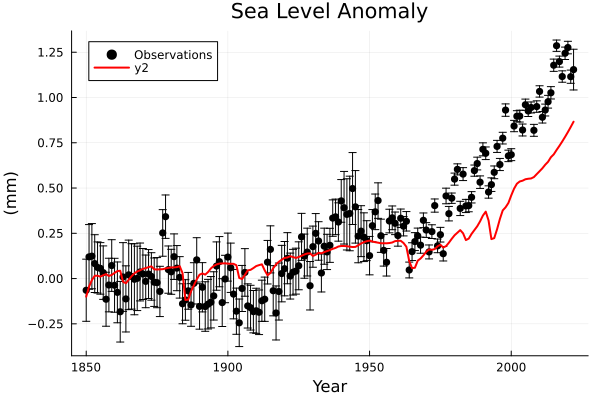

In [283]:
p = scatter(time_obs, temp_obs, yerr=(temp_obs - temp_lo, temp_hi - temp_obs), color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")
pred = ebm_wrap((3.0, 2.9, 1.2, 90.0, 800.0, -0.1))
plot!(time_obs, pred, linewidth=2, color=:red)


## Model Calibration 1: Gaussian iid Errors

In [322]:
# now the params include the standard deviation of the error model as well
function gaussian_iid_homosked(params, temp_dat, temp_err, m)
    S, γ, α, d, D, T₀, σ = params 
    ebm_sim = m((S, γ, α, d, D, T₀))
#    ll = sum(logpdf.(Normal.(ebm_sim, sqrt.(σ^2 .+ temp_err.^2)), temp_dat))
    ll = sum(logpdf.(Normal.(ebm_sim, σ), temp_dat))
    return ll
end

gaussian_iid_homosked (generic function with 2 methods)

In [323]:
lower = [1.0, 0.5, 0.0, 50.0, 200.0, temp_lo[1], 0.0]
upper = [5.0, 1.5, 2.0, 200.0, 1000.0, temp_hi[1], 10.0]
p0 = [3.0, 1.0, 1.0, 100.0, 800.0,temp_obs[1], 5.0]

result = Optim.optimize(params -> -gaussian_iid_homosked(params, temp_obs, temp_sd, ebm_wrap), lower, upper, p0)
θ_iid = result.minimizer

7-element Vector{Float64}:
   4.999999999999999
   1.4999999999999998
   1.0981629187824333
 199.99999999999997
 274.88585107288424
  -0.15807651104164674
   0.12889663034905346

In [281]:
temp_iid = ebm_wrap(θ_iid)


173-element Vector{Float64}:
 -0.14588494257942594
 -0.08295712384982158
 -0.03540080290573086
 -2.6701635472962948e-5
  0.009091626692090108
  0.009971904287814545
  0.023277382140278136
  0.03407382390723749
  0.02611442473331896
  0.034581701146246056
  ⋮
  1.059978718475509
  1.0829721375057693
  1.1125914894933104
  1.1407564102599688
  1.1703692194871007
  1.2015628301488126
  1.2342246562930916
  1.2686489146675328
  1.305005138873844

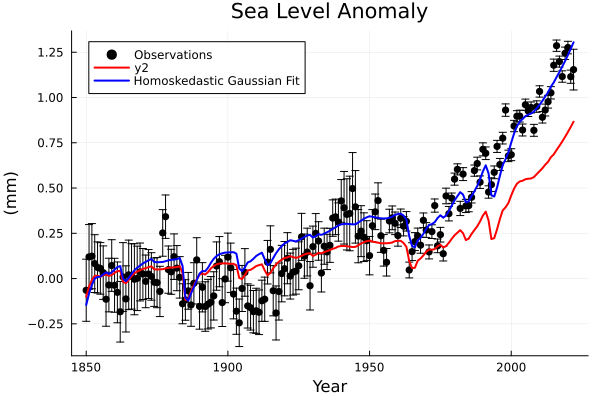

In [284]:
plot!(p, time_obs, temp_iid, color=:blue, linewidth=2, label="Homoskedastic Gaussian Fit")

In [288]:
function ar_covariance_mat(σ, ρ, y_err)
    H = abs.((1:length(y_err)) .- (1:(length(y_err)))') # compute the outer product to get the correlation lags
    ζ_var = σ^2 / (1-ρ^2)
    Σ = ρ.^H * ζ_var
    for i in 1:length(y_err)
         Σ[i, i] += y_err[i]^2
      end
    return Σ
end

function ar_loglik(params, temp_obs, temp_err, m)
    S, γ, α, d, D, T₀, ρ, σ = params 
    ebm_sim = m((S, γ, α, d, D, T₀))

    # whiten residuals
    Σ = ar_covariance_mat(σ, ρ, temp_err)
    residuals = temp_obs - ebm_sim
    ll = logpdf(MvNormal(zeros(length(temp_obs)), Σ), residuals)
    return ll
end


ar_loglik (generic function with 2 methods)

In [290]:
lower = [1.0, 0.5, 0.0, 50.0, 200.0, temp_lo[1], -1.0, 0.0]
upper = [5.0, 1.5, 2.0, 200.0, 1000.0, temp_hi[1], 1.0, 10.0]
p0 = [3.0, 1.0, 1.0, 100.0, 800.0,temp_obs[1], 0.0, 5.0]

result = Optim.optimize(params -> -ar_loglik(params, temp_obs, temp_sd, ebm_wrap), lower, upper, p0)
θ_ar = result.minimizer
@show θ_iid;
@show θ_ar;


θ_iid = [3.434813347287254, 1.4999999999994997, 0.9512307790765135, 77.79722699799284, 623.6996912849185, -0.14588494257942594, 0.08907669883057316]
θ_ar = [3.584285111706408, 1.4999999999999998, 0.9835908096630349, 109.75325618929658, 529.6329965318615, -0.09701545573943057, 0.6645825804763007, 0.08180150317496854]


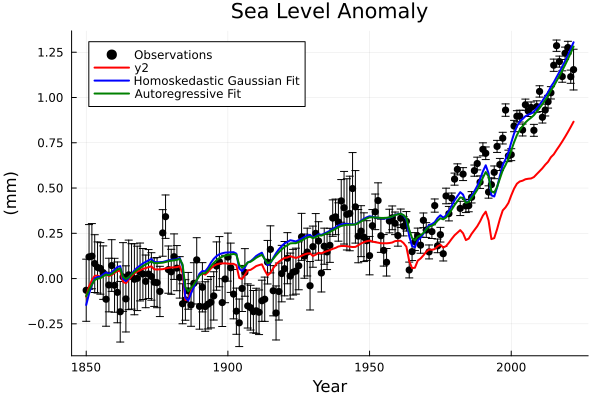

In [291]:
temp_ar = ebm_wrap(θ_ar)
plot!(p, time_obs, temp_ar, color=:green, linewidth=2, label="Autoregressive Fit")


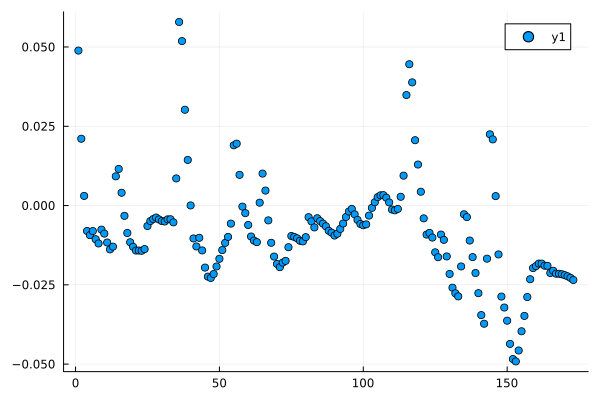

In [292]:
scatter(temp_ar - temp_iid)

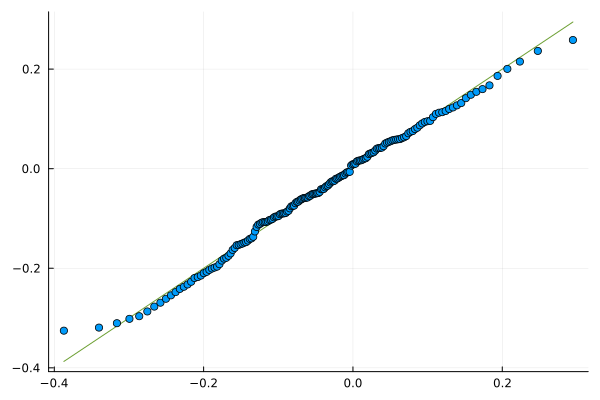

In [293]:
resids_homogauss = temp_obs - temp_iid
qqnorm(resids_homogauss)


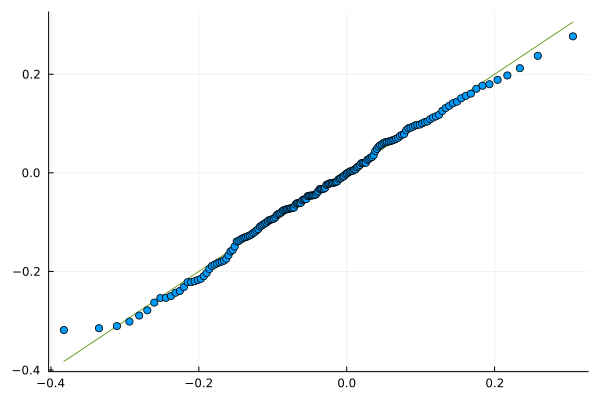

In [294]:
resids_ar = temp_obs - temp_ar
qqnorm(resids_ar)

In [295]:
pacf_homogauss = pacf(resids_homogauss, 1:5)

5-element Vector{Float64}:
  0.5491086835948301
 -0.009480820607957468
  0.1863734967302035
  0.19438591259644586
 -0.05108438561935873

In [298]:
pacf_ar = pacf(resids_ar, 1:5)

5-element Vector{Float64}:
  0.5660439574621867
  0.008812882568429244
  0.19316902277295037
  0.204400569988847
 -0.03335730150601631

## Projections

In [315]:
n = 10_000
ebm_sim(params) = ebm(forcing_non_aerosol_26[sim_idx], forcing_aerosol_26[sim_idx], p = params)

# iid residuals
residuals_iid = rand(Normal(0, θ_iid[end]), (length(sim_idx), n))
model_iid = ebm_sim(θ_iid[1:end-1])
model_sim_iid = (residuals_iid .+ model_iid)'
q90_iid = mapslices(col -> quantile(col, [0.05, 0.5, 0.95]), model_sim_iid; dims=1) # compute 90% prediction interval


3×251 Matrix{Float64}:
 -0.292228    -0.232162   -0.182528   …  1.97479  1.97528  1.96973  1.97025
 -0.146025    -0.0832601  -0.0355681     2.12239  2.11778  2.11647  2.11786
  0.00172193   0.0627791   0.112607      2.26724  2.26819  2.26405  2.26619

In [316]:

# AR residuals
y_err = zeros(length(sim_idx))
y_err[1:length(idx)] = temp_sd
Σ = ar_covariance_mat(θ_ar[end], θ_ar[end-1], zeros(length(sim_idx)))
residuals_ar = rand(MvNormal(zeros(length(sim_idx)), Σ), n)
model_ar = ebm_sim(θ_ar[1:end-2])

model_sim_ar = (residuals_ar .+ model_ar)'
q90_ar = mapslices(col -> quantile(col, [0.05, 0.5, 0.95]), model_sim_ar; dims=1) # compute 90% prediction interval


3×251 Matrix{Float64}:
 -0.278162   -0.240086   -0.210508   …  2.0663   2.06203  2.06683  2.06437
 -0.0966318  -0.0632806  -0.0311805     2.246    2.24548  2.24488  2.24195
  0.0826291   0.1173      0.144914      2.43083  2.43099  2.42615  2.42506

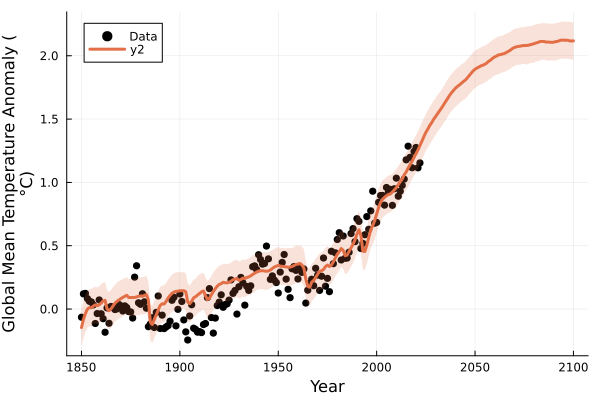

In [317]:
p_sim = scatter(time_obs, temp_obs, color=:black, label="Data", ylabel="Global Mean Temperature Anomaly (
°C)", xlabel="Year")
plot!(p_sim, sim_years, q90_iid[2, :], ribbon=(q90_iid[2, :] - q90_iid[1, :], q90_iid[3, :] - q90_iid[2, :]), fillalpha=0.2, linewidth=3)


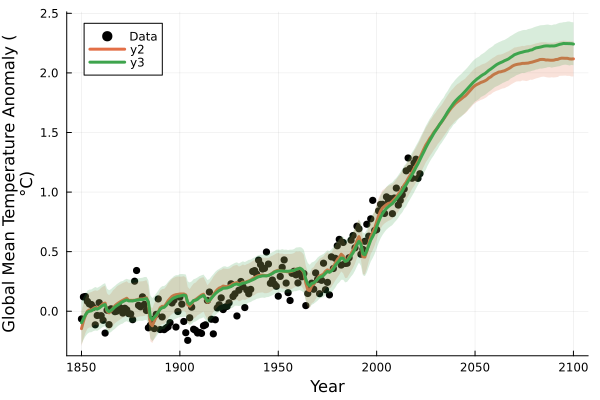

In [318]:
plot!(p_sim, sim_years, q90_ar[2, :], ribbon=(q90_ar[2, :] - q90_ar[1, :], q90_ar[3, :] - q90_ar[2, :]), fillalpha=0.2, linewidth=3)

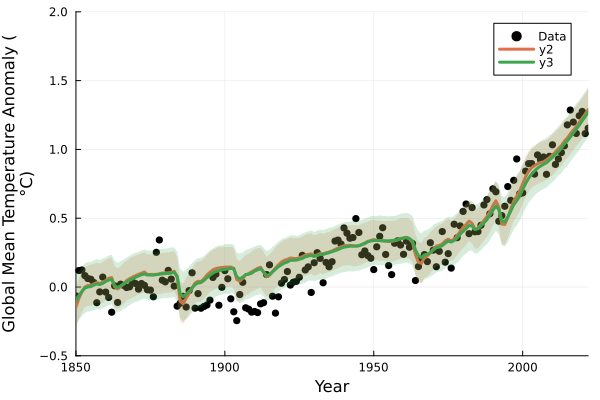

In [319]:
xlims!(p_sim, (1850, 2022))
ylims!(p_sim, (-0.5, 2))

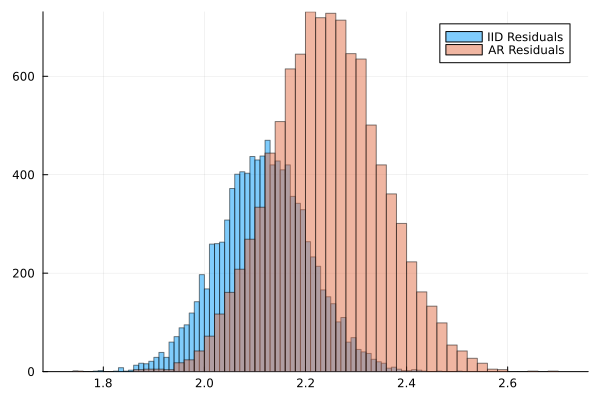

In [320]:
histogram(model_sim_iid[:, end], alpha=0.5, label="IID Residuals")
histogram!(model_sim_ar[:, end], alpha=0.5, label="AR Residuals")

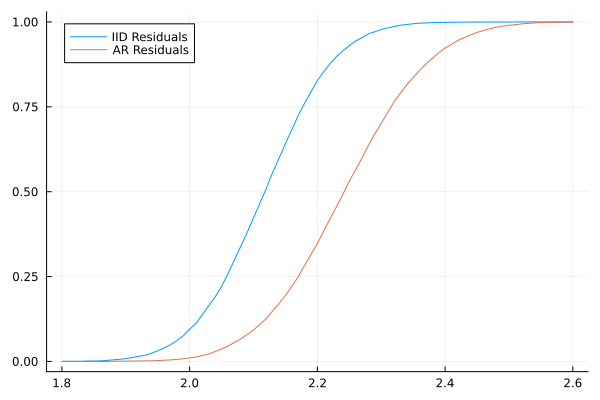

In [321]:
ecdf_iid = ecdf(model_sim_iid[:, end])
ecdf_ar = ecdf(model_sim_ar[:, end])
temp_range = 1.8:0.01:2.6

cd_iid = ecdf_iid.(temp_range)
cd_ar = ecdf_ar.(temp_range)

plot(temp_range, cd_iid, label="IID Residuals")
plot!(temp_range, cd_ar, label="AR Residuals")